In [3]:
import numpy as np
from scipy import optimize
from types import SimpleNamespace

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
class Labor_supply:
    def __init__(self,w,**kwargs):
        self.param = SimpleNamespace()
        param = self.param
        param.m = 1     # endowment
        param.Ϟ = 10    # labor disutility scaler
        param.ε = 0.3   # Frisch elasticity
        param.τ0 = 0.4  # labor income tax
        param.τ1 = 0.1  # high income tax 
        param.κ = 0.4   # cut-off point of high income tax
        self.w = w      # exogenous wage

        # Update values according to kwargs
        for key, value in kwargs.items():
            setattr(self.param,key,value) # like self.key = value

    def implied_tax(self,l):
        param = self.param
        τ0 , τ1, κ = param.τ0, param.τ1, param.κ
        w = self.w
        tax = τ0*w*l + τ1*np.fmax(w*l-κ,0)
        return tax

    def consumption(self,l):
        """ calculate consumption
        Args: 
            l: labor supply
        Returns:
            consumption value
        """
        param = self.param
        m = param.m
        w = self.w
        implied_tax = self.implied_tax(l)
        c = m + w*l - implied_tax
        if c<0:
            raise ValueError('The consumption becomes negative')
        else:
            return c
    
    def utility(self,l):
        param = self.param
        ε = param.ε
        Ϟ = param.Ϟ
        c = self.consumption(l)
        u = np.log(c) - Ϟ*l**(1+1/ε)/(1+1/ε)
        return u
    
    def solv(self):
        obj = lambda l: - self.utility(l)
        opt_choice = optimize.minimize_scalar(obj,bounds=(0,1),method='bounded')
        if not opt_choice.success:
            raise ValueError('optimizer is failed')
        else: 
            l = opt_choice.x
            c = self.consumption(l)
            t = self.implied_tax(l)
            u = self.utility(l)
            return l, c, t, u

In [92]:
help(Labor_supply.consumption)

Help on function consumption in module __main__:

consumption(self, l)
    calculate consumption
    Args:
        l: labor supply
    Returns:
        consumption value



In [93]:

# number of households
N = 100
w_min = 0.5
w_max = 1.5
w_vec = np.linspace(w_min,w_max,N)

housholds = [ Labor_supply(w=w_vec[i]) for i in range(N)]
l_vec = np.zeros(N)
c_vec = np.zeros(N)

for i in range(N):
    l_vec[i]=housholds[i].solv()[0]
    c_vec[i]=housholds[i].solv()[1]
    
# print(f'{l_vec} \n')
# print(f'{c_vec} \n')
# print(f'{w_vec}')

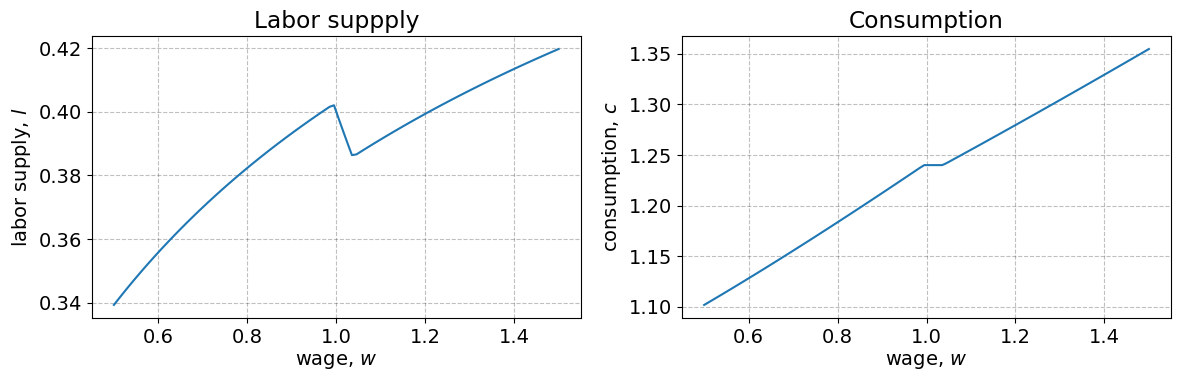

In [94]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(w_vec,l_vec,'-')
ax.set_ylabel('labor supply, $l$')
ax.set_xlabel('wage, $w$')
ax.set_title('Labor suppply')

ax = fig.add_subplot(1,2,2)
ax.plot(w_vec,c_vec,'-')
ax.set_ylabel('consumption, $c$')
ax.set_xlabel('wage, $w$')
ax.set_title('Consumption')

fig.tight_layout(pad=1.0)

### Calculate total tax revenue

In [95]:
Tax_Revenue = sum(housholds[i].solv()[2] for i in range(N))
print(Tax_Revenue)

16.31019011475859


##  What determines the tax revenue?

1. Change tax parameters?
2. Change preference parameters or initial ressources?
3. Change the utility function?
4. Change the distribution of wages? (e.g. log-normal or Pareto)

In [98]:
K=1000
τ0_vec = np.linspace(0.01,0.5,K)
Revenue_vec = np.zeros(K)
for j in range(K):
    housholds = [ Labor_supply(w=w_vec[i] , τ0=τ0_vec[j]) for i in range(N)]
    Revenue_vec[j] = sum(housholds[i].solv()[2] for i in range(N))

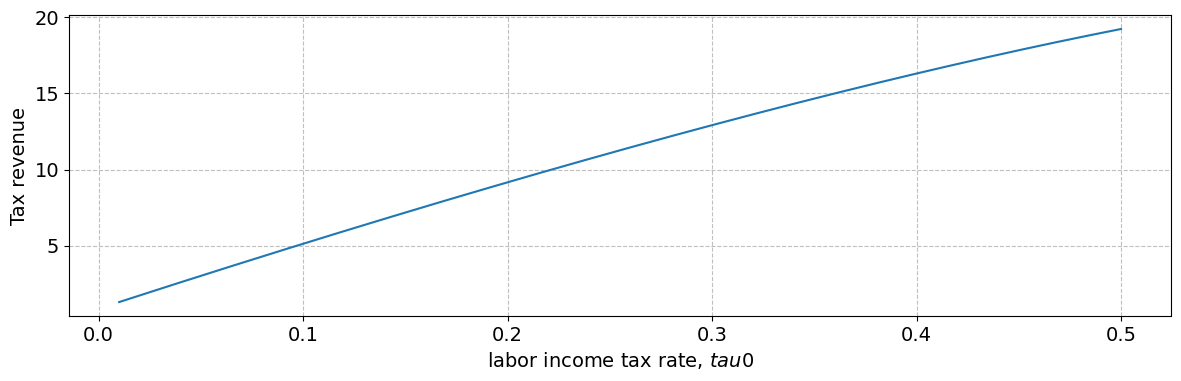

In [104]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,1,1)
ax.plot(τ0_vec,Revenue_vec,'-')
ax.set_ylabel('Tax revenue')
ax.set_xlabel('labor income tax rate, $tau0$')
fig.tight_layout(pad=1.0)